# Evaluation Elevator Detection Pipeline

In [1]:
import random

from termcolor import cprint
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
    get_detection_dataset_dicts,
    build_detection_test_loader,
)
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer, ColorMode

from detection_pipeline import ElevatorDetector
from data_utils import read_split_file, register_dataset


### Instantiate Detection pipeline

Configure the segmentation model and recovery model using the dicts below

In [2]:
instance_segmentation_cfg = {
    "arch": "cascade_mask_rcnn",
    "weights": "new_models/mrcnn101/model_best.pth",
    "score_thresh": 0.7,
}

recovery_cfg = {
    "arch": "cascade_mask_rcnn",
    "weights": "new_models/recovery_model/model_best.pth",
    "score_thresh": 0.7,
}

model = ElevatorDetector(instance_segmentation_cfg, recovery_cfg)


### Load testing dataset

In [3]:
im_paths = "data/panels/mixed/split.txt"
datasets = read_split_file(im_paths)
test_im_paths = datasets[-1]

### Register Dataset and Metadata with Detectron2 

In [4]:
DatasetCatalog.register(
    "test", func=lambda im_paths=test_im_paths: register_dataset(im_paths=im_paths)
)
MetadataCatalog.get("test").thing_classes = ["label", "button"]
metadata = MetadataCatalog.get("test")

In [5]:
testset = get_detection_dataset_dicts("test", filter_empty=False)
cprint(f"testset size: {len(testset)}", "green")

testset size: 20


### Randomly sample 3 examples from the test 

Display ground truth annotations

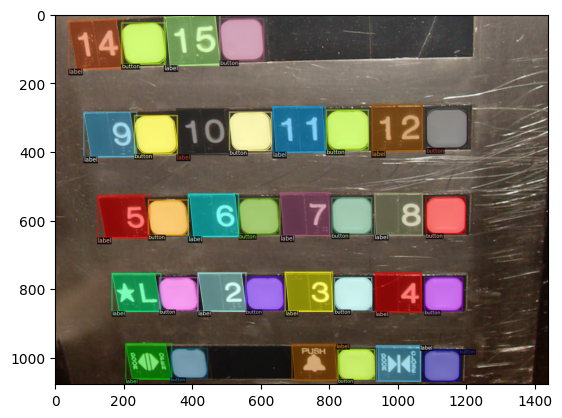

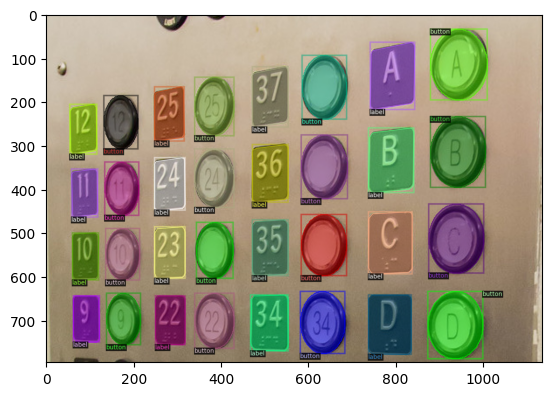

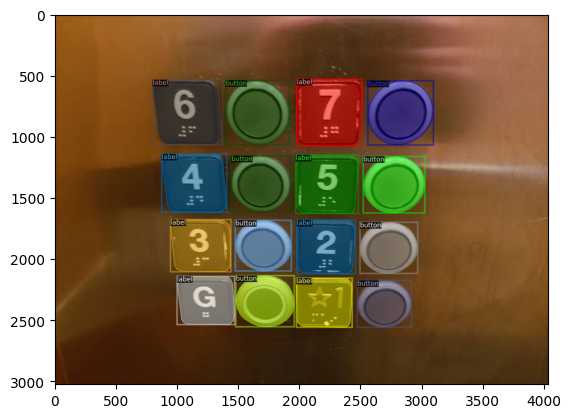

In [6]:
for d in random.sample(testset, 3):
    im = cv2.imread(d["file_name"])
    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=2.0)
    out = v.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.show()

### Run Evaluation on Testset using COCO metrics

In [7]:
cfg = get_cfg()
cfg.DATASETS.TEST = ("test",)

In [8]:
testloader = build_detection_test_loader(cfg, "test")
evaluator = COCOEvaluator(
    "test", output_dir="./eval_results", use_fast_impl=False, allow_cached_coco=False
)
print(inference_on_dataset(model, testloader, evaluator))

/home/abhinavchadaga/miniforge3/envs/d2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.747
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.956
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.891
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.799
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.403
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

### Rerun Evaluation without the recovery model

In [9]:
model_no_recovery = ElevatorDetector(
    instance_segmentation_cfg, use_recovery=False
)
print(inference_on_dataset(model_no_recovery, testloader, evaluator))

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.748
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.947
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.890
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.799
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.754
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.761
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.407
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.799
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10